# Info
Name:  

    ORACLES_AOD_profile

Purpose:  

    Comparison of AOD from 4STAR over a profile
    Additional calculations of the aerosol extinction profile
  
Input:

    none at command line
  
Output:

    figures and save files...
  
Keywords:

    none
  
Dependencies:

    - load_utils.py : for loading OMI HDF5 files
    - matplotlib
    - numpy
    - scipy : for saving and reading
    - pytables
    - os
    - path_utils.pu: for setting up proper paths in a cross device manner
  
Needed Files:

  - file.rc : for consistent creation of look of matplotlib figures
  - ...
  
Modification History:

    Written: Samuel LeBlanc, OSAN AFB, Korea, 2016-05-09
    Modified: Samuel LeBlanc, Swakopmund, Namibia, 2016-09-05
              ported from KORUS
    Modified: Samuel LeBlanc, Santa Cruz, CA, 2017-11-22
              Added new plotting for the special case of 2016-09-20 and updated the data inputs

# Import the required modules and set up base


In [11]:
%config InlineBackend.rc = {}
import matplotlib 
import os
matplotlib.rc_file(os.path.join(os.getcwd(),'file.rc'))
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import scipy.io as sio
import Sp_parameters as Sp
import tables
import load_utils as lm
from path_utils import getpath
import hdf5storage as hs
%matplotlib notebook

In [3]:
fp = getpath('ORACLES')
fp

u'/mnt/c/Users/sleblanc/Research/ORACLES/'

In [4]:
from mpl_toolkits.basemap import Basemap,cm
from Sp_parameters import deriv, smooth

# Load the various data

## Load the 4STAR starsun


In [6]:
dd = '20160920'

In [13]:
f_star = fp+'data/4STAR_{}starsun.mat'.format(dd)

In [14]:
s = sio.loadmat(f_star)

In [15]:
s.keys()

['El_gnd',
 'Str',
 'tau_O3_err',
 'sza',
 'nirfilen',
 'toggle',
 'pitch',
 'Tst',
 'fwhm',
 'nirt',
 'tau_aero_noscreening',
 'rateaero',
 'O3h',
 'NO2col',
 'Headng',
 'RH',
 'Pst',
 'nirheader',
 'nirdatatype',
 'sd_aero_crit',
 'tau_aero_err',
 'dark',
 'nirVdettemp',
 'Elstep',
 'flagfilename',
 'tau_ray',
 'nircols',
 'sunaz',
 'O3col',
 'm_ray',
 'm_err',
 'forj_corr',
 'tau_O4_err',
 'flagallcolsitems',
 't',
 'c0mod',
 'tau_tot_slant',
 'track_err',
 'flagallcols',
 '__header__',
 'rate',
 'daystr',
 'rawrelstd',
 'program_version',
 'sat_time',
 'm_O3',
 'tau_aero_err2',
 'visheader',
 'Az_deg',
 'nirTint',
 'flagfilenameNO2',
 'filename',
 'tau_r_err',
 'high_alt_c0',
 'nirsat_pixel',
 'Md',
 'aeronetcols',
 'rateslant',
 'visAVG',
 'tau_NO2_err',
 'Zn',
 'AZstep',
 'langley',
 'darkstd',
 'visdatatype',
 'QdVtot',
 'tau_aero_err7',
 'tau_aero_err6',
 'tau_aero_err5',
 'nirAVG',
 'tau_aero_err3',
 'sun_sky_Az_offset',
 'w',
 'ELcorr',
 'visVdettemp_C',
 'tau_aero_err8',
 'E

In [16]:
s['utc'] = lm.toutc(lm.mat2py_time(s['t']))

## Get the flag file

In [18]:
fmat = getpath('4STAR_data',make_path=True,path='/mnt/c/Users/sleblanc/Research/4STAR_codes/data_folder/')

In [19]:
s_flag = fmat+'20160920_starflag_man_created20161005_1603by_CF.mat'

In [8]:
s_flag = 'C:\\Users\\sleblan2\\Research\\4STAR_codes\\data_folder\\{dd}_starflag_man_created20160904_1609by_SL.mat'.format(dd)

In [21]:
sf = hs.loadmat(s_flag)

In [22]:
sf.keys()

[u'unspecified_clouds',
 u'manual_flags',
 u'bad_aod',
 u'flagfile',
 u'flag_struct',
 u'screen',
 u'frost',
 u'spiral',
 u'before_or_after_flight',
 u'hor_legs',
 u'flags',
 u'low_cloud',
 u'smoke',
 u'time',
 u'dust',
 u'screened',
 u'cirrus',
 u't']

In [62]:
ifl = (np.array(sf['bad_aod'])==0) & (np.array(sf['unspecified_clouds'])==0) & (np.array(sf['cirrus'])==0)
ifl = ifl.flatten()

In [71]:
iflt = ((ifl) & (s['utc']>=11.8667) & (s['utc']<=12.25))
iflt = iflt.flatten()

In [75]:
print 'total utc points', s['utc'].shape, 'valid', ifl.shape,'valid during profile:',iflt.shape,\
      'selected valid',ifl.sum(),'selected valid during profile',iflt.sum()

total utc points (18178,) valid (18178,) valid during profile: (18178,) selected valid 15662 selected valid during profile 749


## Plot some early 4STAR data

<IPython.core.display.Javascript object>


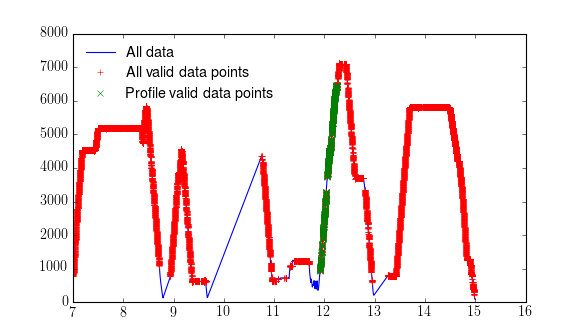

In [87]:
plt.figure()
plt.plot(s['utc'],s['Alt'],label='All data')
plt.plot(s['utc'][ifl],s['Alt'][ifl],'+r',label='All valid data points')
plt.plot(s['utc'][iflt],s['Alt'][iflt],'xg',label='Profile valid data points')
plt.legend(loc=2,numpoints=1,frameon=False)

<IPython.core.display.Javascript object>


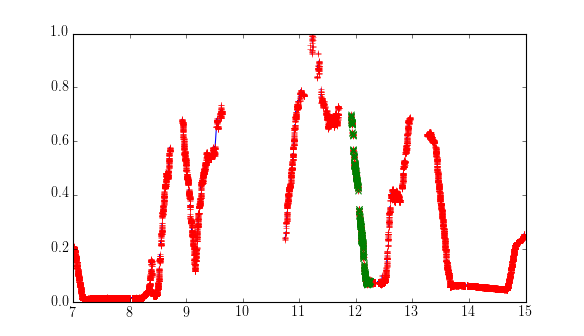

In [88]:
plt.figure()
plt.plot(s['utc'],s['tau_aero'][:,400])
plt.plot(s['utc'][ifl],s['tau_aero'][ifl,400],'+r')
plt.plot(s['utc'][iflt],s['tau_aero'][iflt,400],'xg')

<IPython.core.display.Javascript object>


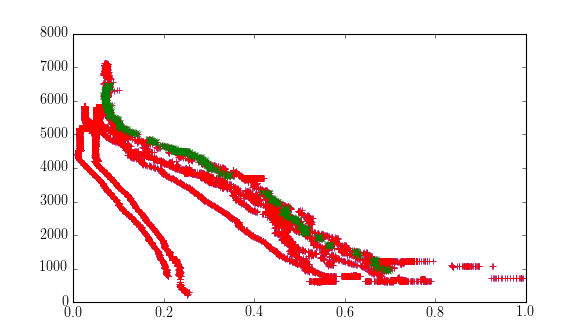

In [89]:
plt.figure()
plt.plot(s['tau_aero'][:,400],s['Alt'],'+')
plt.plot(s['tau_aero'][ifl,400],s['Alt'][ifl],'+r')
plt.plot(s['tau_aero'][iflt,400],s['Alt'][iflt],'xg')


In [90]:
# profile = [13.24,13.56] for 20160904
profile = [11.8667, 12.25]

In [91]:
it = (s['utc']>=profile[0]) & (s['utc']<=profile[1]) & (ifl) & (s['tau_aero'][:,400]<0.8)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [92]:
it = it.flatten()

## Load the 4STAR dirty clean correction file

In [394]:
s_dirty = fmat+'20160920_AOD_merge_marks.mat'

In [395]:
dm = sio.loadmat(s_dirty)

In [396]:
dm.keys()

['dCo',
 'dAODs',
 'AODs',
 '__header__',
 'wl_nm',
 '__globals__',
 'm_aero',
 'time',
 '__version__']

In [397]:
dm['utc'] = lm.toutc(lm.mat2py_time(dm['time']))

### Create a full wavelength tau correction from polyfit

In [416]:
import Sun_utils as su
from scipy import polyval
from write_utils import nearest_neighbor

In [400]:
dm['dAODs'].shape

(36090, 24)

Get the nearest neighboring daod values, matched to the utc time in the starsun.mat file

In [449]:
daod = []
for i,iv in enumerate(dm['wl_nm'].flatten()):
    da = nearest_neighbor(dm['dAODs'][:,i],dm['utc'],s['utc'],dist=1.0/3600)
    daod.append(da)
    break
daod = np.array(daod)
daod.shape

(1, 18178)

<IPython.core.display.Javascript object>


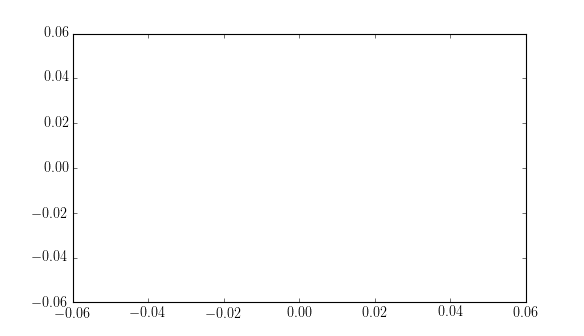

In [450]:
plt.figure()
plt.plot(da)

In [432]:
dm['polyaod'] = [su.aod_polyfit(dm['wl_nm'].flatten(),daod[:,i],polynum=4) for i in xrange(len(s['utc']))]    
np.shape(dm['polyaod'])

In [434]:
dm['tau'] = [polyval(dm['polyaod'][i].flatten(),s['w'].flatten()*1000.0) for i in xrange(len(s['utc']))] 

In [444]:
np.shape(dm['tau'])

(18178, 1556)

In [414]:
s['tau_aero'].shape

(18178, 1556)

In [435]:
aod = s['tau_aero']-np.array(dm['tau'])

In [436]:
aod.shape

(18178, 1556)

### Plot to ensure proper correction

<IPython.core.display.Javascript object>


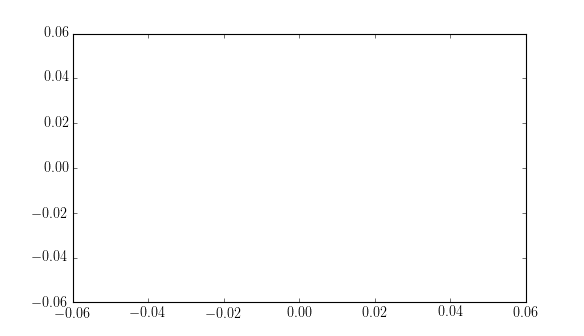

In [447]:
plt.figure()
#plt.plot(dm['utc'],dm['dAODs'][:,4],'k.')
plt.plot(s['utc'],daod[4,:],'r.')
plt.plot(s['utc'],np.array(dm['tau'])[:,400],'b.')
plt.plot(s['utc'],aod[:,400],'g.')

# Plot the geographical region and add context

In [93]:
#set up a easy plotting function
def make_map(ax=plt.gca()):
    m = Basemap(projection='stere',lon_0=14.0,lat_0=-22.0,
            llcrnrlon=-10.0, llcrnrlat=-25.0,
            urcrnrlon=20.0, urcrnrlat=0,resolution='h',ax=ax)
    m.drawcoastlines()
    #m.fillcontinents(color='#AAAAAA')
    m.drawstates()
    m.drawcountries()
    m.drawmeridians(np.linspace(-10,20,11),labels=[0,0,0,1])
    m.drawparallels(np.linspace(-25,1,14),labels=[1,0,0,0])
    return m


<IPython.core.display.Javascript object>


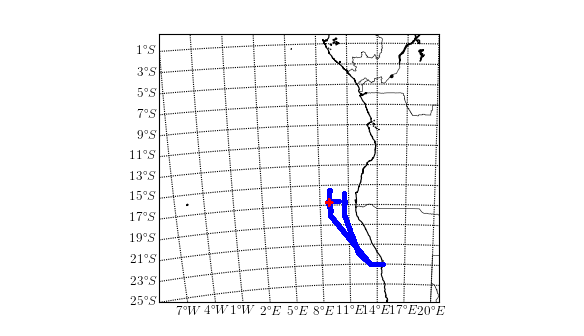

In [95]:
fig,ax = plt.subplots(1,1)
m = make_map(ax)
m.plot(s['Lon'],s['Lat'],'b.',latlon=True)
m.plot(s['Lon'][it],s['Lat'][it],'r+',latlon=True)
plt.savefig(fp+'plot/map_take_off_profile_{dd}.png'.format(dd=dd),dpi=600,transparent=True)

# Now plot the vertical distribution of AOD and Extinction

## Vertical profile of AOD

In [384]:
i515 = np.argmin(abs(s['w']*1000.0-515.0))
i380 = np.argmin(abs(s['w']*1000.0-380.0))
i865 = np.argmin(abs(s['w']*1000.0-865.0))
i1250 = np.argmin(abs(s['w']*1000.0-1250.0))

In [97]:
ii = np.where(it)[0][-3]

In [98]:
tau_max = 1.0

In [99]:
ii

11006

In [100]:
s['tau_aero'].shape

(18178, 1556)

<IPython.core.display.Javascript object>


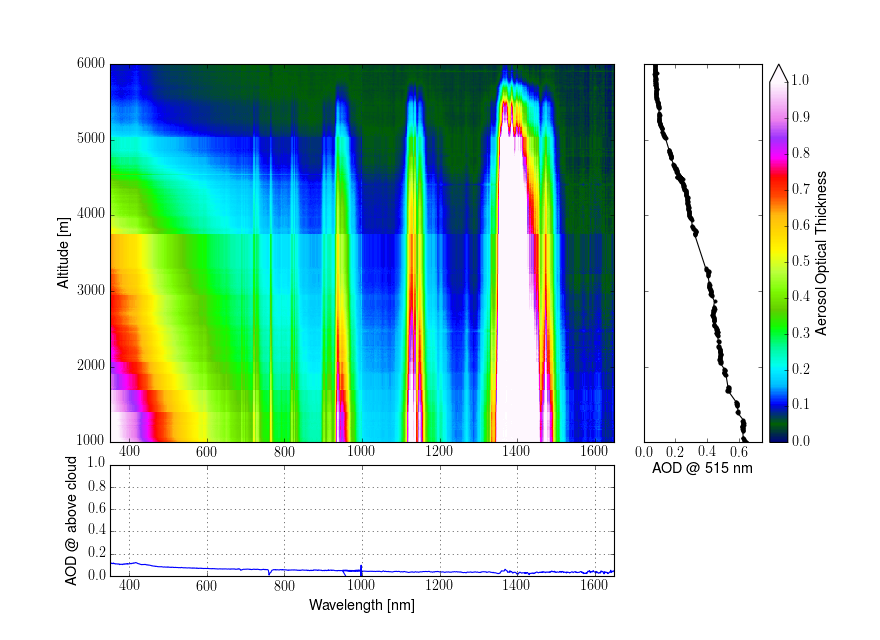

In [102]:
fig = plt.figure(figsize=(11,8))
plt.title('{} profile at {}h'.format(dd,profile[0]))
ax = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=3)
cb = ax.pcolorfast(s['w'].flatten()*1000.0,s['Alt'][it].flatten(),s['tau_aero'][it,:][:-1,:-1],
                   cmap='gist_ncar',vmin=0,vmax=tau_max)
ax.set_xscale('log')
ax2 = plt.subplot2grid((4,4),(0,3),sharey=ax,rowspan=3)

ax2.plot(s['tau_aero'][it,i515],s['Alt'][it],'k.-')
axc = plt.colorbar(cb,extend='max')
axc.set_label('Aerosol Optical Thickness')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([1000,6000])
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,0.2,0.4,0.6])
ax2.set_xlim([0.0,tau_max*0.75])
ax2.set_xlabel('AOD @ 515 nm')

ax3 = plt.subplot2grid((4,4),(3,0),sharex=ax,colspan=3)
ax3.plot(s['w'].flatten()*1000.0,s['tau_aero'][ii,:].flatten())
ax.set_xlim([350,1650])
ax3.set_ylim([0.00,tau_max])
ax3.grid()
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('AOD @ above cloud')
plt.setp(ax.get_xticklabels(), visible=True)
plt.savefig(fp+'plot/AOD_Alt_profile_{}.png'.format(dd),dpi=600,transparent=True)

In [161]:
u = np.where(it)[0]
iit = u[np.linspace(0,len(u)-1,6).astype(int)]

In [129]:
tau_max = 1.2

In [156]:
w_archive = [354.9,380.0,451.7,470.2,500.7,520,530.3,532.0,550.3,605.5,619.7,660.1,675.2,699.7,780.6,864.6,1019.9,1039.6,1064.2,1235.8,1249.9,1558.7,1626.6,1650.1]
iw_archive = [np.argmin(abs(s['w']*1000.0-i)) for i in w_archive]

<IPython.core.display.Javascript object>


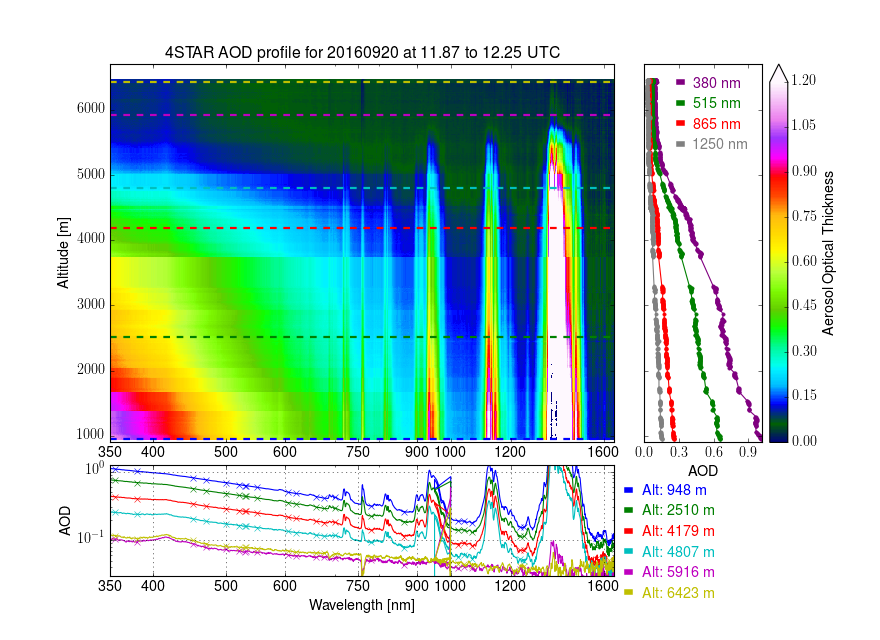

In [462]:
fig = plt.figure(figsize=(11,8))
plt.title('{} profile at {}h'.format(dd,profile[0]))
ax = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=3)
cb = ax.pcolor(s['w'].flatten()*1000.0,s['Alt'][it].flatten(),s['tau_aero'][it,:][:-1,:-1],
                   cmap='gist_ncar',vmin=0,vmax=tau_max)
plt.xscale('log')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([900,6700])
ax.set_xscale('log')

ax2 = plt.subplot2grid((4,4),(0,3),sharey=ax,rowspan=3)

ax2.plot(s['tau_aero'][it,i380],s['Alt'][it],'.-',color='purple',label='380 nm')
ax2.plot(s['tau_aero'][it,i515],s['Alt'][it],'g.-',label='515 nm')
ax2.plot(s['tau_aero'][it,i865],s['Alt'][it],'r.-',label='865 nm')
ax2.plot(s['tau_aero'][it,i1250],s['Alt'][it],'.-',color='grey',label='1250 nm')

plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,0.3,0.6,0.9])
ax2.set_xlim([0.0,tau_max*0.85])
ax2.set_xlabel('AOD')
ax2.set_ylim([900,6700])
leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
axc = plt.colorbar(cb,extend='max')
axc.set_label('Aerosol Optical Thickness')

ax3 = plt.subplot2grid((4,4),(3,0),sharex=ax,colspan=3)
for i in iit:
    p =ax3.plot(s['w'].flatten()*1000.0,s['tau_aero'][i,:].flatten(),label='Alt: {:4.0f} m'.format(s['Alt'][i][0]))
    p =ax3.plot(s['w'].flatten()[iw_archive]*1000.0,s['tau_aero'][i,iw_archive].flatten(),'x',color=p[0].get_color())
    ax.axhline(s['Alt'][i][0],ls='--',color=p[0].get_color(),lw=2)
ax.set_xlim([350,1650])
ax3.set_ylim([0.03,tau_max*1.05])
ax.set_xscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax.set_xticks([350,400,500,600,750,900,1000,1200,1600])
ax.set_xticklabels([350,400,500,600,750,900,1000,1200,1600])
ax3.grid()
leg = ax3.legend(frameon=False,loc=2,numpoints=1,bbox_to_anchor=(1.0,0.94),handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('AOD')
ax.set_title('4STAR AOD profile for {dd} at {t0:2.2f} to {t1:2.2f} UTC'.format(dd=dd,t0=profile[0],t1=profile[1]))
plt.setp(ax.get_xticklabels(), visible=True)
plt.savefig(fp+'plot/AOD_Alt_profile_loglog_{}.png'.format(dd),dpi=600,transparent=True)

<IPython.core.display.Javascript object>


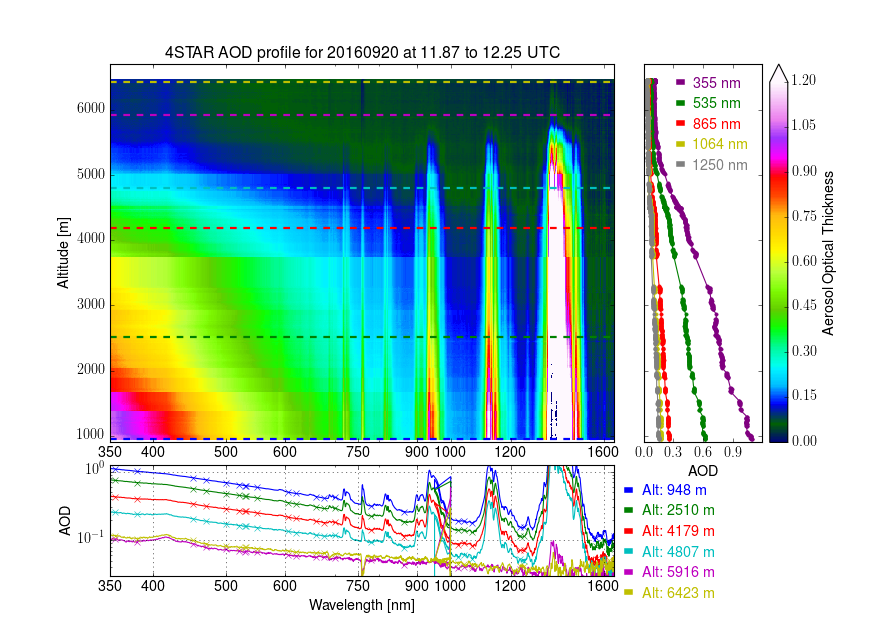

In [465]:
fig = plt.figure(figsize=(11,8))
plt.title('{} profile at {}h'.format(dd,profile[0]))
ax = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=3)
cb = ax.pcolor(s['w'].flatten()*1000.0,s['Alt'][it].flatten(),s['tau_aero'][it,:][:-1,:-1],
                   cmap='gist_ncar',vmin=0,vmax=tau_max)
plt.xscale('log')
ax.set_ylabel('Altitude [m]')
ax.set_ylim([900,6700])
ax.set_xscale('log')

ax2 = plt.subplot2grid((4,4),(0,3),sharey=ax,rowspan=3)

i532 = np.argmin(abs(s['w']*1000.0-532.0))
i355 = np.argmin(abs(s['w']*1000.0-355.0))
i1064 = np.argmin(abs(s['w']*1000.0-1064.0))

ax2.plot(s['tau_aero'][it,i355],s['Alt'][it],'.-',color='purple',label='355 nm')
ax2.plot(s['tau_aero'][it,i532],s['Alt'][it],'g.-',label='535 nm')
ax2.plot(s['tau_aero'][it,i865],s['Alt'][it],'r.-',label='865 nm')
ax2.plot(s['tau_aero'][it,i1064],s['Alt'][it],'.-',color='y',label='1064 nm')
ax2.plot(s['tau_aero'][it,i1250],s['Alt'][it],'.-',color='grey',label='1250 nm')

plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,0.3,0.6,0.9])
ax2.set_xlim([0.0,tau_max])
ax2.set_xlabel('AOD')
ax2.set_ylim([900,6700])
leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
axc = plt.colorbar(cb,extend='max')
axc.set_label('Aerosol Optical Thickness')

ax3 = plt.subplot2grid((4,4),(3,0),sharex=ax,colspan=3)
for i in iit:
    p =ax3.plot(s['w'].flatten()*1000.0,s['tau_aero'][i,:].flatten(),label='Alt: {:4.0f} m'.format(s['Alt'][i][0]))
    p =ax3.plot(s['w'].flatten()[iw_archive]*1000.0,s['tau_aero'][i,iw_archive].flatten(),'x',color=p[0].get_color())
    ax.axhline(s['Alt'][i][0],ls='--',color=p[0].get_color(),lw=2)
ax.set_xlim([350,1650])
ax3.set_ylim([0.03,tau_max*1.05])
ax.set_xscale('log')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax.set_xticks([350,400,500,600,750,900,1000,1200,1600])
ax.set_xticklabels([350,400,500,600,750,900,1000,1200,1600])
ax3.grid()
leg = ax3.legend(frameon=False,loc=2,numpoints=1,bbox_to_anchor=(1.0,0.94),handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('AOD')
ax.set_title('4STAR AOD profile for {dd} at {t0:2.2f} to {t1:2.2f} UTC'.format(dd=dd,t0=profile[0],t1=profile[1]))
plt.setp(ax.get_xticklabels(), visible=True)
plt.savefig(fp+'plot/AOD_Alt_profile_loglog_hsrlwvl_{}.png'.format(dd),dpi=600,transparent=True)

### Add the angstrom exponent vertical dependence

In [163]:
import Sun_utils as su

In [239]:
s['polyaod'] = []
s['polylogaod'] = []

In [240]:
for i in np.where(it)[0]:
    pp = su.aod_polyfit(s['w'].flatten()[iw_archive]*1000.0,s['tau_aero'][i,iw_archive],polynum=4)
    s['polyaod'].append(pp)
    pl = su.logaod_polyfit(s['w'].flatten()[iw_archive]*1000.0,s['tau_aero'][i,iw_archive],polynum=4)
    s['polylogaod'].append(pl)
s['polyaod'] = np.array(s['polyaod'])
s['polylogaod'] = np.array(s['polylogaod'])

In [387]:
s['angs'] = su.angstrom_from_logpoly(s['polylogaod'],[380.0,515.0,865.0,1250.0],polynum=4)

In [388]:
s['angs'].shape

(740, 4)

<IPython.core.display.Javascript object>


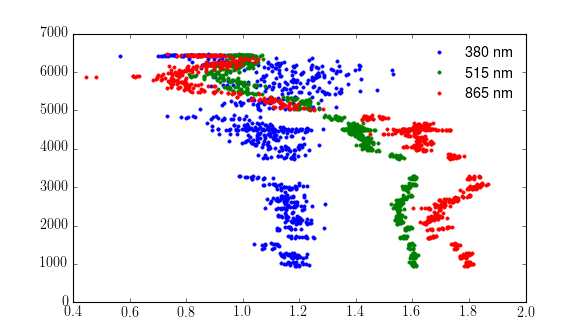

In [364]:
plt.figure()
plt.plot(s['angs'][:,0],s['Alt'][it],'.',label='380 nm')
plt.plot(s['angs'][:,1],s['Alt'][it],'.',label='515 nm')
plt.plot(s['angs'][:,2],s['Alt'][it],'.',label='865 nm')
plt.legend(numpoints=1,frameon=False)

In [374]:
def smoothb(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [453]:
fig = plt.figure(figsize=(11,7))
plt.title('{} profile at {}h'.format(dd,profile[0]))
fig.subplots_adjust(wspace=0.1)
ax = plt.subplot2grid((4,5),(0,0),colspan=3,rowspan=3)
cb = ax.pcolorfast(s['w'].flatten()*1000.0,s['Alt'][it].flatten(),s['tau_aero'][it,:][:-1,:-1],
                   cmap='gist_ncar',vmin=0,vmax=tau_max)
ax.set_ylabel('Altitude [m]')
ax.set_ylim([900,6700])
ax.set_xscale('log')

ax2 = plt.subplot2grid((4,5),(0,3),sharey=ax,rowspan=3)

ax2.plot(s['tau_aero'][it,i380],s['Alt'][it],'.-',color='purple',label='380 nm')
ax2.plot(s['tau_aero'][it,i515],s['Alt'][it],'g.-',label='515 nm')
ax2.plot(s['tau_aero'][it,i865],s['Alt'][it],'r.-',label='865 nm')
ax2.plot(s['tau_aero'][it,i1250],s['Alt'][it],'.-',color='grey',label='1250 nm')

plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,0.3,0.6,0.9])
ax2.set_xlim([0.0,tau_max*0.85])
ax2.set_xlabel('AOD')
ax2.set_ylim([900,6700])
ax2.grid()
leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
axa = plt.subplot2grid((4,5),(0,4),sharey=ax,rowspan=3)
plt.plot(smoothb(s['angs'][:,0],10),s['Alt'][it],'.-',color='purple',label='380 nm')
plt.plot(smoothb(s['angs'][:,1],10),s['Alt'][it],'g.-',label='515 nm')
plt.plot(smoothb(s['angs'][:,2],10),s['Alt'][it],'r.-',label='865 nm')
#plt.plot(smoothb(s['angs'][:,3],10),s['Alt'][it],'.-',color='grey',label='1250 nm')
plt.setp(axa.get_yticklabels(), visible=False)
axa.set_xticks([0.8,1.2,1.6,2.0])
axa.set_xlim([0.6,2.0])
axa.set_xlabel('Angstrom')
axa.set_ylim([900,6700])
axa.grid()

axc = plt.colorbar(cb,extend='max')
axc.set_label('Aerosol Optical Thickness')

ax3 = plt.subplot2grid((4,5),(3,0),sharex=ax,colspan=3)
for i in iit:
    p =ax3.plot(s['w'].flatten()*1000.0,s['tau_aero'][i,:].flatten(),label='Alt: {:4.0f} m'.format(s['Alt'][i][0]))
    p =ax3.plot(s['w'].flatten()[iw_archive]*1000.0,s['tau_aero'][i,iw_archive].flatten(),'x',color=p[0].get_color())
    ax.axhline(s['Alt'][i][0],ls='--',color=p[0].get_color(),lw=2)
ax.set_xlim([350,1650])
ax3.set_ylim([0.00,tau_max])
ax.set_xscale('log')
ax3.set_xscale('log')
ax.set_xticks([350,400,500,600,700,850,1000,1200,1600])
ax.set_xticklabels([350,400,500,600,700,850,1000,1200,1600])
ax3.grid()
leg = ax3.legend(frameon=False,loc=2,numpoints=1,bbox_to_anchor=(1.0,0.94),handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('AOD')
plt.setp(ax.get_xticklabels(), visible=True)

ax.set_title('4STAR AOD profile for {dd} at {t0:2.2f} to {t1:2.2f} UTC'.format(dd=dd,t0=profile[0],t1=profile[1]))

plt.savefig(fp+'plot/AOD_Alt_profile_log_angstrom_{}.png'.format(dd),dpi=600,transparent=True)

<IPython.core.display.Javascript object>

AttributeError: Unknown property xr

## Redo but with the dirty corrected data

<IPython.core.display.Javascript object>


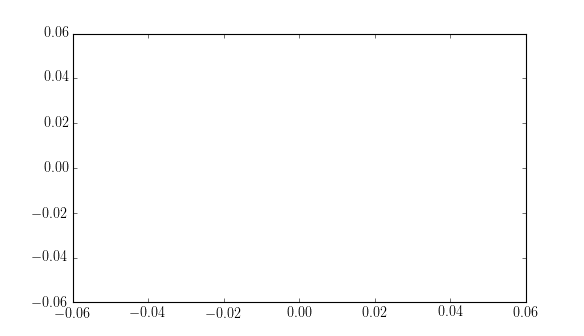

In [441]:
plt.figure()
plt.plot(s['utc'],aod[:,400])

In [437]:
polylogaod = np.array([su.logaod_polyfit(s['w'].flatten()[iw_archive]*1000.0,aod[i,iw_archive],polynum=4) for i in np.where(it)[0]])

In [438]:
angs = su.angstrom_from_logpoly(polylogaod,[380.0,515.0,865.0,1250.0],polynum=4)

In [440]:
fig = plt.figure(figsize=(12,8))
plt.title('{} profile at {}h'.format(dd,profile[0]))
fig.subplots_adjust(wspace=0.1)
ax = plt.subplot2grid((4,5),(0,0),colspan=3,rowspan=3)
cb = ax.pcolorfast(s['w'].flatten()*1000.0,s['Alt'][it].flatten(),aod[it,:][:-1,:-1],
                   cmap='gist_ncar',vmin=0,vmax=tau_max)
ax.set_ylabel('Altitude [m]')
ax.set_ylim([900,6700])
ax.set_xscale('log')

ax2 = plt.subplot2grid((4,5),(0,3),sharey=ax,rowspan=3)

ax2.plot(aod[it,i380],s['Alt'][it],'.-',color='purple',label='380 nm')
ax2.plot(aod[it,i515],s['Alt'][it],'g.-',label='515 nm')
ax2.plot(aod[it,i865],s['Alt'][it],'r.-',label='865 nm')
ax2.plot(aod[it,i1250],s['Alt'][it],'.-',color='grey',label='1250 nm')

plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,0.3,0.6,0.9])
ax2.set_xlim([0.0,tau_max*0.85])
ax2.set_xlabel('AOD')
ax2.set_ylim([900,6700])
ax2.grid()
leg = ax2.legend(frameon=False,loc=1,numpoints=1,markerscale=0,handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
    
axa = plt.subplot2grid((4,5),(0,4),sharey=ax,rowspan=3)
plt.plot(smoothb(angs[:,0],10),s['Alt'][it],'.-',color='purple',label='380 nm')
plt.plot(smoothb(angs[:,1],10),s['Alt'][it],'g.-',label='515 nm')
plt.plot(smoothb(angs[:,2],10),s['Alt'][it],'r.-',label='865 nm')
#plt.plot(smoothb(s['angs'][:,3],10),s['Alt'][it],'.-',color='grey',label='1250 nm')
plt.setp(axa.get_yticklabels(), visible=False)
axa.set_xticks([0.8,1.2,1.6,2.0])
axa.set_xlim([0.6,2.0])
axa.set_xlabel('Angstrom')
axa.set_ylim([900,6700])
axa.grid()

axc = plt.colorbar(cb,extend='max')
axc.set_label('Aerosol Optical Thickness')

ax3 = plt.subplot2grid((4,5),(3,0),sharex=ax,colspan=3)
for i in iit:
    p =ax3.plot(s['w'].flatten()*1000.0,aod[i,:].flatten(),label='Alt: {:4.0f} m'.format(s['Alt'][i][0]))
    p =ax3.plot(s['w'].flatten()[iw_archive]*1000.0,aod[i,iw_archive].flatten(),'x',color=p[0].get_color())
    ax.axhline(s['Alt'][i][0],ls='--',color=p[0].get_color(),lw=2)
ax.set_xlim([350,1650])
ax3.set_ylim([0.00,tau_max])
ax.set_xscale('log')
ax3.set_xscale('log')
ax.set_xticks([350,400,500,600,700,850,1000,1200,1600])
ax.set_xticklabels([350,400,500,600,700,850,1000,1200,1600])
ax3.grid()
leg = ax3.legend(frameon=False,loc=2,numpoints=1,bbox_to_anchor=(1.0,0.94),handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
ax3.set_xlabel('Wavelength [nm]')
ax3.set_ylabel('AOD')
plt.setp(ax.get_xticklabels(), visible=True)

ax.set_title('4STAR AOD profile for {dd} at {t0:2.2f} to {t1:2.2f} UTC'.format(dd=dd,t0=profile[0],t1=profile[1]))

#plt.savefig(fp+'plot/AOD_Alt_profile_log_angstrom_dirty_corrected{}.png'.format(dd),dpi=600,transparent=True)

<IPython.core.display.Javascript object>

ValueError: Data has no positive values, and therefore can not be log-scaled.

## Vertical profile of extinction

In [103]:
from Sp_parameters import deriv,smooth

In [104]:
s['ext'] = np.zeros_like(s['tau_aero'])

In [105]:
for l,w in enumerate(s['w'][0]):
    s['ext'][it,l] = smooth(deriv(smooth(s['tau_aero'][it,l],3,nan=False,old=True),
                                  s['Alt'][it][:,0])*-1000000.0,5,nan=False,old=True)

Sp_parameters.py:113: RuntimeWarning: divide by zero encountered in true_divide
  d[i] = y[i-1]*(x[i]-x[i+1])/((x[i-1]-x[i])*(x[i-1]-x[i+1])) +                y[i]*(1.0/(x[i]-x[i+1]) - 1.0/(x[i-1]-x[i])) -                y[i+1]*(x[i-1]-x[i])/((x[i-1]-x[i+1])*(x[i]-x[i+1]))
Sp_parameters.py:113: RuntimeWarning: invalid value encountered in double_scalars
  d[i] = y[i-1]*(x[i]-x[i+1])/((x[i-1]-x[i])*(x[i-1]-x[i+1])) +                y[i]*(1.0/(x[i]-x[i+1]) - 1.0/(x[i-1]-x[i])) -                y[i+1]*(x[i-1]-x[i])/((x[i-1]-x[i+1])*(x[i]-x[i+1]))
Sp_parameters.py:113: RuntimeWarning: divide by zero encountered in double_scalars
  d[i] = y[i-1]*(x[i]-x[i+1])/((x[i-1]-x[i])*(x[i-1]-x[i+1])) +                y[i]*(1.0/(x[i]-x[i+1]) - 1.0/(x[i-1]-x[i])) -                y[i+1]*(x[i-1]-x[i])/((x[i-1]-x[i+1])*(x[i]-x[i+1]))


<IPython.core.display.Javascript object>


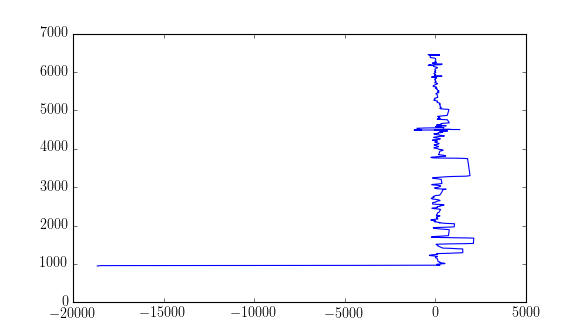

In [106]:
plt.figure()
plt.plot(s['ext'][it,400],s['Alt'][it])

<IPython.core.display.Javascript object>


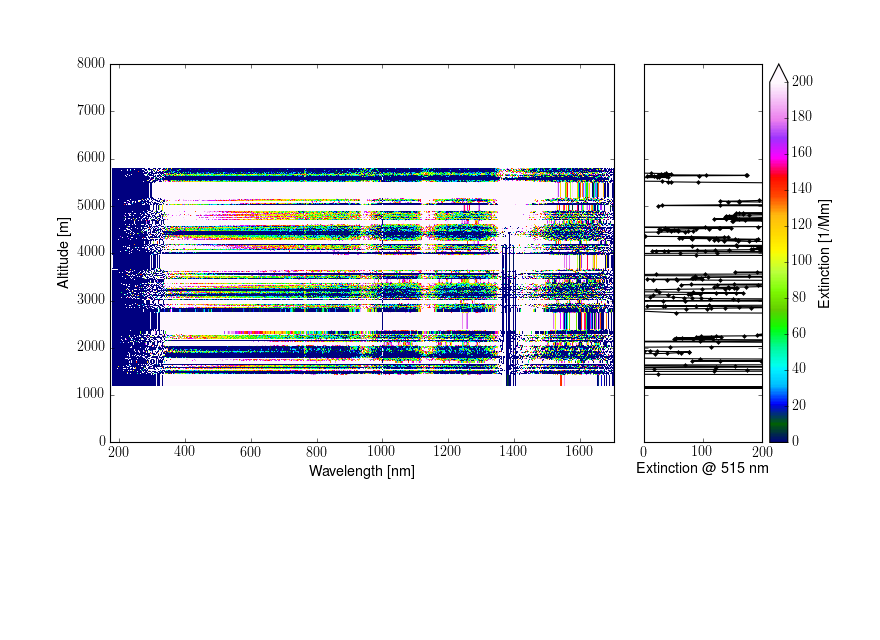

In [118]:
fig = plt.figure(figsize=(11,8))
ax = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=3)
cb = ax.pcolorfast(s['w'].flatten()*1000.0,s['Alt'][it].flatten(),s['ext'][it,:][:-1,:-1],
                   cmap='gist_ncar',vmin=0,vmax=200.0)
ax2 = plt.subplot2grid((4,4),(0,3),sharey=ax,rowspan=3)
ax2.plot(s['ext'][it,i515],s['Alt'][it],'k.-')
axc = plt.colorbar(cb,extend='max')
axc.set_label('Extinction [1/Mm]')
ax.set_ylabel('Altitude [m]')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylim([0,8000])
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.set_xticks([0.0,100.0,200.0])
ax2.set_xlim([0.0,200.0])
ax2.set_xlabel('Extinction @ 515 nm')

#ax3 = plt.subplot2grid((4,4),(3,0),sharex=ax,colspan=3)
#ax3.plot(s['w'].flatten()*1000.0,s['ext'][ii,:].flatten())
#ax.set_xlim([350,1650])
#ax3.set_ylim([0,200.0])
#ax3.grid()
#ax3.set_xlabel('Wavelength [nm]')
#ax3.set_ylabel('AOT')
#plt.setp(ax.get_xticklabels(), visible=False)
plt.savefig(fp+'plot\\Ext_Alt_profile_{dd}.png'.format(dd=dd),dpi=600,transparent=True)

# Now load the HSRL data and plot that

In [467]:
import hdf5storage as hs

In [468]:
import load_utils as lu

In [469]:
fp

u'/mnt/c/Users/sleblanc/Research/ORACLES/'

In [472]:
hsrl = lu.load_hdf(fp+'data_other/HSRL2_ER2_20160920_R4.h5')

Outputting the Data subdatasets:
0: [2479x1392] //DataProducts/1064_aer_dep (64-bit floating-point)
1: [2479x1392] //DataProducts/1064_bsc (64-bit floating-point)
2: [2479x1392] //DataProducts/1064_bsc_Sa (64-bit floating-point)
3: [2479x1392] //DataProducts/1064_bsc_cloud_screened (64-bit floating-point)
4: [2479x1392] //DataProducts/1064_bsr (64-bit floating-point)
5: [2479x1392] //DataProducts/1064_bsr_cloud_screened (64-bit floating-point)
6: [2479x1392] //DataProducts/1064_dep (64-bit floating-point)
7: [2479x1392] //DataProducts/1064_ext (64-bit floating-point)
8: [2479x1392] //DataProducts/1064_total_attn_bsc (64-bit floating-point)
9: [2479x1] //DataProducts/355_AOT_above_cloud (64-bit floating-point)
10: [2479x1] //DataProducts/355_AOT_hi (64-bit floating-point)
11: [2479x1392] //DataProducts/355_AOT_hi_col (64-bit floating-point)
12: [2479x1392] //DataProducts/355_Sa (64-bit floating-point)
13: [2479x1392] //DataProducts/355_aer_dep (64-bit floating-point)
14: [2479x1392] //D

In [473]:
val = (('AOTcum_355',11),('AOTcum_532',24),('ext_1064',7),('Alt',36),('Lat',106),('Lon',107),('GPS_alt',105),('time',108))

In [477]:
hsrl,hsrl_head = lu.load_hdf(fp+'data_other/HSRL2_ER2_20160920_R4.h5',values=val)

Outputting the Data subdatasets:
0: [2479x1392] //DataProducts/1064_aer_dep (64-bit floating-point)
1: [2479x1392] //DataProducts/1064_bsc (64-bit floating-point)
2: [2479x1392] //DataProducts/1064_bsc_Sa (64-bit floating-point)
3: [2479x1392] //DataProducts/1064_bsc_cloud_screened (64-bit floating-point)
4: [2479x1392] //DataProducts/1064_bsr (64-bit floating-point)
5: [2479x1392] //DataProducts/1064_bsr_cloud_screened (64-bit floating-point)
6: [2479x1392] //DataProducts/1064_dep (64-bit floating-point)
7: [2479x1392] //DataProducts/1064_ext (64-bit floating-point)
8: [2479x1392] //DataProducts/1064_total_attn_bsc (64-bit floating-point)
9: [2479x1] //DataProducts/355_AOT_above_cloud (64-bit floating-point)
10: [2479x1] //DataProducts/355_AOT_hi (64-bit floating-point)
11: [2479x1392] //DataProducts/355_AOT_hi_col (64-bit floating-point)
12: [2479x1392] //DataProducts/355_Sa (64-bit floating-point)
13: [2479x1392] //DataProducts/355_aer_dep (64-bit floating-point)
14: [2479x1392] //D

Running through data values: [########################################]100% -- Done! 
['AOTcum_355', 'time', 'Lon', 'ext_1064', 'AOTcum_532', 'GPS_alt', 'Lat', 'Alt']


In [479]:
hsrl['time']

array([[  8.10861111],
       [  8.11166673],
       [  8.11444444],
       ..., 
       [ 15.02263892],
       [ 15.02541672],
       [ 15.02819452]])

In [517]:
ih = np.argmin(abs(hsrl['time']-11.95))

In [484]:
ih

1347

In [497]:
hsrl['Alt']

array([[  -300.    ,   -285.0104,   -270.0208, ...,  20520.5544,
         20535.544 ,  20550.5336]])

## Now plot the vertical HSRL AOT profile corresponding to 4STAR's measurement

<IPython.core.display.Javascript object>


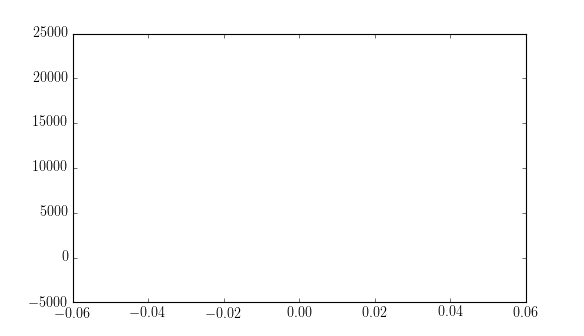

 ...]

In [495]:
plt.figure()
plt.plot(hsrl['Alt'])

<IPython.core.display.Javascript object>


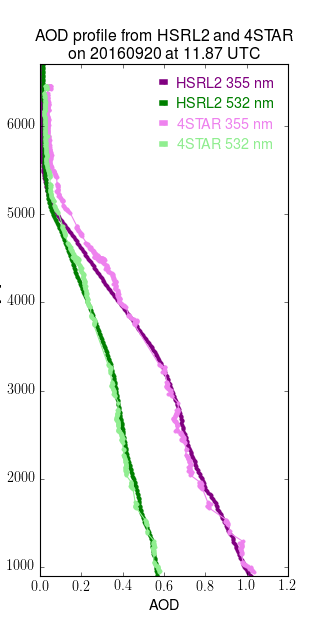

In [519]:
plt.figure(figsize=(4,8))
plt.plot(hsrl['AOTcum_355'][ih,:],hsrl['Alt'].flatten(),'.-',color='purple',label='HSRL2 355 nm')
plt.plot(hsrl['AOTcum_532'][ih,:],hsrl['Alt'].flatten(),'.-',color='g',label='HSRL2 532 nm')

plt.plot(s['tau_aero'][it,i355]-0.065,s['Alt'][it],'.-',color='violet',label='4STAR 355 nm')
plt.plot(s['tau_aero'][it,i532]-0.045,s['Alt'][it],'.-',color='lightgreen',label='4STAR 532 nm')

plt.ylim([900,6700])
plt.xlim([0,tau_max])
plt.xlabel('AOD')
plt.ylabel('Altitude [m]')
leg = plt.legend(frameon=False,loc=1,numpoints=1,handlelength=0.2)
for line,text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())
    line.set_linewidth(5.0)
plt.title('AOD profile from HSRL2 and 4STAR\n on {} at 11.87 UTC'.format(dd))

plt.savefig(fp+'plot/AOD_Alt_profile_vs_HSRL_{}.png'.format(dd),dpi=600,transparent=True)